In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# !pip install tensorflow-gpu --upgrade

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from src.layers import CADenseAdd, CADenseMul
from src.optimizers import SVDAdam, SVDSGD
# from src.models import ContextModelWrapper

In [4]:
np.random.seed(40)

# Data

In [5]:
def make_classification(n_samples, n_features, contexts, alpha, noise_std):
    # Generate data points with normalized feature values and noise
    features = np.random.normal(0, 1, (n_samples, n_features))
    noise = np.random.normal(0, noise_std, (n_samples, n_features))
    # Generate coefficients
    base_coefficients = np.random.uniform(-1/np.sqrt(n_features), 1/np.sqrt(n_features), (n_features))
    interaction_coefficients = np.random.uniform(-1/np.sqrt(n_features), 1/np.sqrt(n_features), (contexts.max() + 1, n_features))
    coefficients = (1 - alpha) * base_coefficients[np.newaxis, :] + alpha * interaction_coefficients[contexts, :]
    # Generate labels
    labels = np.einsum('bd, bd->b', features, coefficients) > 0.0
    return features.astype(np.float32) + noise, labels.astype(np.int32)

In [6]:
n_samples = 8000
n_features = 32
centers = 4
cluster_std = 0.05
center_box = (-1, 1)
alpha = 0.0
noise_std = 0.1

# Make features and targets
context_features, contexts = make_blobs(
    n_samples, n_features, centers=centers, cluster_std=cluster_std, center_box=center_box)
data_features, labels = make_classification(n_samples, n_features, contexts, alpha, noise_std)

In [7]:
split = 0.8
batch_size = 32

# Make floats
data_features = data_features.astype(np.float32)
context_features = context_features.astype(np.float32)

# Split train and test
split_data = train_test_split(data_features, context_features, labels, contexts, train_size=split)
train_data_features, test_data_features, train_context_features, test_context_features, \
train_labels, test_labels, train_contexts, test_contexts = split_data

# Make datasets
input_dataset = tf.data.Dataset.from_tensor_slices(train_data_features)
context_dataset = tf.data.Dataset.from_tensor_slices(train_context_features)
label_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

# Zip dataset and batch
train_ds = tf.data.Dataset.zip((input_dataset, context_dataset, label_dataset)).batch(batch_size)

2022-01-28 13:37:58.185805: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-28 13:38:07.493327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10411 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:19:00.0, compute capability: 6.1
2022-01-28 13:38:07.513835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6 MB memory:  -> device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1
2022-01-28 13:38:07.517273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/devi

# Models

In [8]:
# Loss function & metric
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
metric = lambda x, y : np.mean(x == y)

def evaluate(model):
    if isinstance(model, dict):
        return np.mean([
            metric(value.predict(test_data_features[test_contexts == int(key[-1]), :]), test_labels[test_contexts == int(key[-1])])
            for key, value in model.items()]
        )
    else:
        return metric(model.predict(test_data_features), test_labels)

### Logistic regression

In [9]:
# Logistic regressor
logreg = LogisticRegression()
# Regressors
logreg_dict = {}
# Features only
logreg_dict['features'] = logreg.fit(
    train_data_features, train_labels)
# Features and context
logreg_dict['features+context'] = logreg.fit(
    np.concatenate([train_data_features, train_context_features], axis=-1), train_labels)
# Multiple models
logreg_dict['multiple'] = {
    f'context_{i}': logreg.fit(
        train_data_features[train_contexts == i, :], train_labels[train_contexts == i])
    for i in range(centers)
}

In [10]:
print(f'Logistic Regression, features only test score: {evaluate(logreg_dict["features"])}')
print(f'Logistic Regression, features and context test score: {evaluate(logreg_dict["features+context"])}')
print(f'Multiple Logistic Regression test score: {evaluate(logreg_dict["multiple"])}')

Logistic Regression, features only test score: 0.950625
Logistic Regression, features and context test score: 0.950625
Multiple Logistic Regression test score: 0.9504226706152757


## MLP

In [22]:
# Model parameters
units = n_features
activation = 'relu'
n_layers = 1
targets = 2
projection = 'softmax'
# Training parameters
epochs = 20
verbose = 0
# Optimizer parameters
learning_rate = 10e-3
# Models & histories
model_dict = {}
history_dict = {}

In [12]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

###Without context
# Model
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(units, activation) for _ in range(n_layers + 1)] + [tf.keras.layers.Dense(targets, projection)])
# Compile
model.compile(optimizer, loss_fn, metrics=metric_fn)
# Train model
history = model.fit(
    train_data_features, train_labels, validation_data=(test_data_features, test_labels), epochs=epochs, verbose=verbose)
# Add model to dict
model_dict['features'] = model
history_dict['features'] = history

### With context
# Model
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(units, activation) for _ in range(n_layers + 1)] + [tf.keras.layers.Dense(targets, projection)])
# Compile
model.compile(optimizer, loss_fn, metrics=metric_fn)
# Train model
history = model.fit(
    np.concatenate([train_data_features, train_context_features], axis=-1), train_labels, 
    validation_data=(np.concatenate([test_data_features, test_context_features], axis=-1), test_labels),
    epochs=epochs, verbose=verbose)
# Add model to dict
model_dict['features+context'] = model
history_dict['features+context'] = history

### SVD

In [13]:
# Additional model parameters
rank = centers
projection_rank = centers
# Additional optimizer parameters
nu = learning_rate

In [14]:
from src.optimizers.utils import unpack
import types 

def context_train_step(self, data):
    """Training step"""
    # Unpack
    (x, c), y = data
    # Get gradients
    with tf.GradientTape() as tape:
        y_pred = self((x, c), training=True)
        loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        trainable_variables = self.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
    # Make gradients and variables zip
    grads_and_vars = zip(gradients, trainable_variables)
    # Optimize variables
    self.optimizer.apply_gradients(grads_and_vars, c)
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

In [30]:
# Architecture
inputs = tf.keras.layers.Input([n_features], name='input', batch_size=batch_size)
context = tf.keras.layers.Input([n_features], name='context', batch_size=batch_size)
hidden = inputs
for i in range(n_layers):
    hidden = CADenseAdd(units, rank, activation, name=f'layer_{i}')([hidden, context])
outputs = CADenseAdd(targets, projection_rank, projection)([hidden, context])
# Model
model = tf.keras.models.Model(inputs=(inputs, context), outputs=outputs)
# Wrap model for train step modification
model.train_step = types.MethodType(context_train_step, model)
# Optimizer
optimizer = SVDAdam(model, None, learning_rate, nu)
# Compile
model.compile(optimizer, loss_fn, metrics=metric_fn)
# Train model
history = model.fit(x=(train_data_features, train_context_features), y=train_labels, 
    validation_data=((test_data_features, test_context_features), test_labels),
    epochs=epochs, verbose=verbose, batch_size=batch_size)
# Add model to dict
model_dict['additive'] = model
history_dict['additive'] = history

In [31]:
# Architecture
inputs = tf.keras.layers.Input([n_features], name='input', batch_size=batch_size)
context = tf.keras.layers.Input([n_features], name='context', batch_size=batch_size)
hidden = inputs
for i in range(n_layers):
    hidden = CADenseMul(units, rank, activation)([hidden, context])
outputs = CADenseMul(targets, projection_rank, projection)([hidden, context])
# Model
model = tf.keras.models.Model(inputs=(inputs, context), outputs=outputs)
# Wrap model for train step modification
model.train_step = types.MethodType(context_train_step, model)
# Optimizer
optimizer = SVDAdam(model, None, learning_rate, nu)
# Compile
model.compile(optimizer, loss_fn, metrics=metric_fn)
# Train model
history = model.fit(x=(train_data_features, train_context_features), y=train_labels, 
    validation_data=((test_data_features, test_context_features), test_labels),
    epochs=epochs, verbose=verbose, batch_size=batch_size)
# Add model to dict
model_dict['multiplicative'] = model
history_dict['multiplicative'] = history

In [23]:
# Architecture
inputs = tf.keras.layers.Input([n_features], name='input', batch_size=batch_size)
context = tf.keras.layers.Input([n_features], name='context', batch_size=batch_size)
hidden = inputs
for i in range(n_layers):
    hidden = tf.keras.layers.Dense(units, activation)(hidden)
hidden = hidden * tf.keras.activations.get('sigmoid')(context)
outputs = tf.keras.layers.Dense(targets, projection)(hidden)
# Model
model = tf.keras.models.Model(inputs=(inputs, context), outputs=outputs)
# Wrap model for train step modification
model.train_step = types.MethodType(context_train_step, model)
# Optimizer
optimizer = SVDAdam(model, None, learning_rate, nu)
# Compile
model.compile(optimizer, loss_fn, metrics=metric_fn)
# Train model
history = model.fit(x=(train_data_features, train_context_features), y=train_labels, 
    validation_data=((test_data_features, test_context_features), test_labels),
    epochs=epochs, verbose=verbose, batch_size=batch_size)
# Add model to dict
model_dict['gated'] = model
history_dict['gated'] = history

# Plotting

In [16]:
from matplotlib import cm
cmap = cm.get_cmap('viridis', 1 + len(list(model_dict.values())))  # matplotlib color palette name, n colors

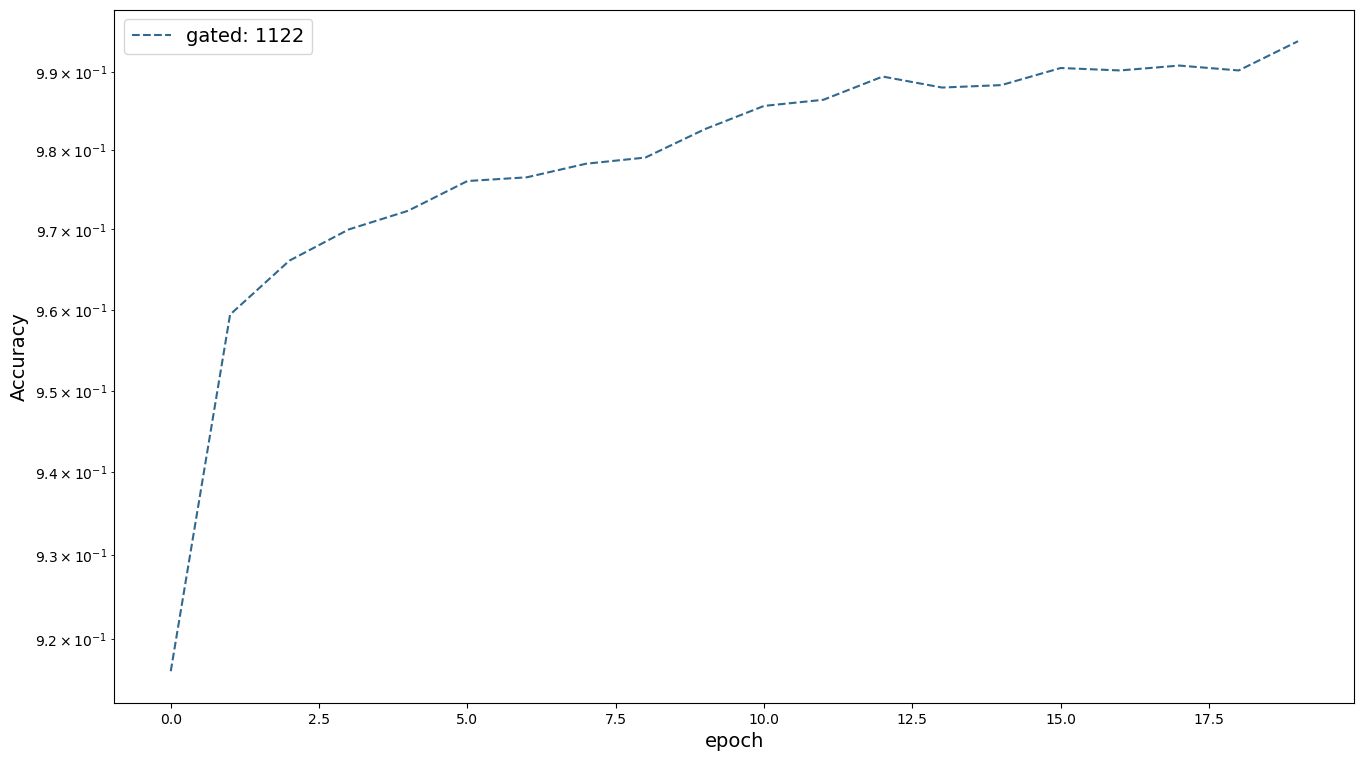

In [24]:
plt.style.use('default')
fig = plt.figure(figsize=(16, 9))
for i, (key, history) in enumerate(history_dict.items()):
    plt.plot(history.history['sparse_categorical_accuracy'], linestyle='dashed', color=cmap(1 + i), 
             label=f'{key}: {np.sum([s.numpy().size for s in model_dict[key].trainable_variables])}')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.yscale('log')
plt.show()

In [18]:
# fig.savefig('temp_results')

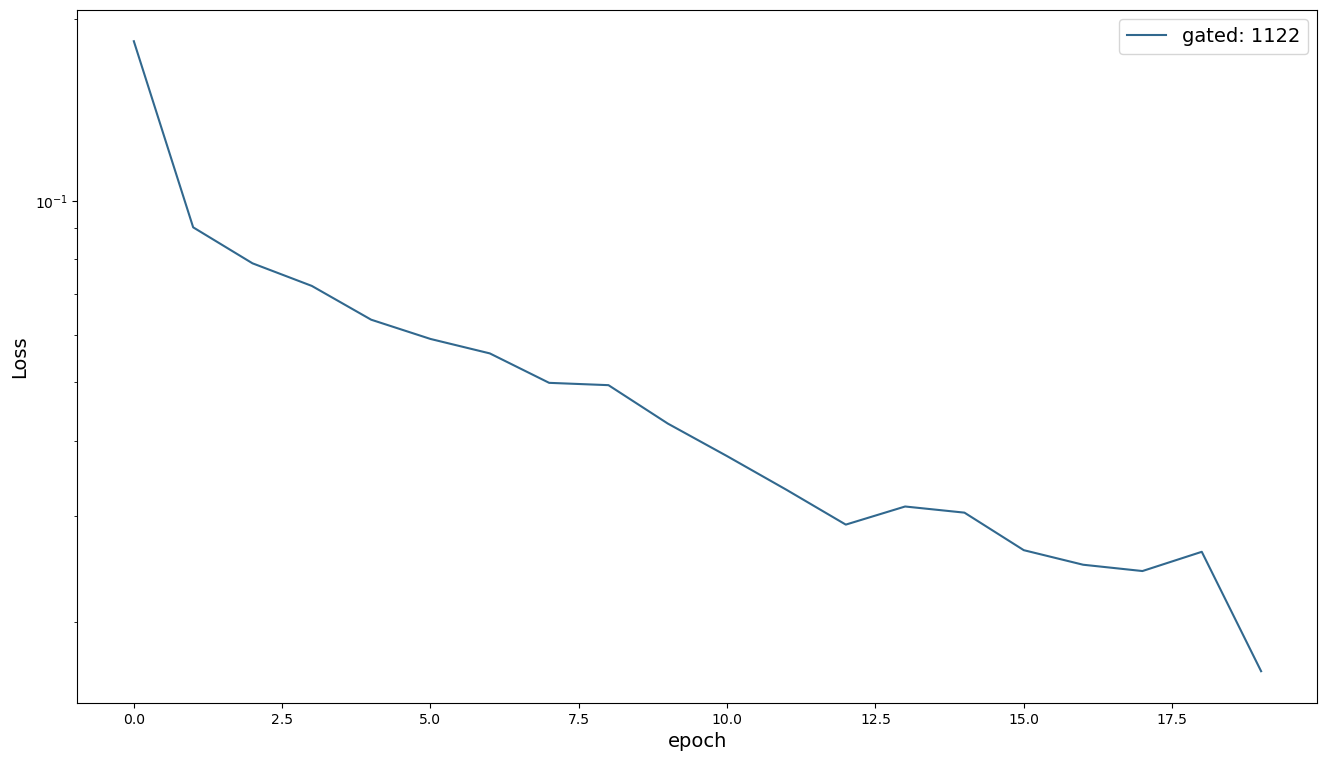

In [26]:
# plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 9))
for i, (key, history) in enumerate(history_dict.items()):
    plt.plot(history.history['loss'], color=cmap(1 + i),
             label=f'{key}: {np.sum([s.numpy().size for s in model_dict[key].trainable_variables])}')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.yscale('log')
plt.show()

In [20]:
# fig.savefig(f'H: {n_layers}, N: {n_features}, lr: {learning_rate}, nu: {learning_rate}, alpha: {alpha}.jpg')

In [25]:
metric(np.argmax(model_dict['gated']((test_data_features, test_context_features)), -1), test_labels)

0.93625

In [55]:
metric(np.argmax(model_dict['additive']((test_data_features, test_context_features)), -1), test_labels)

KeyError: 'additive'

In [40]:
metric(np.argmax(model_dict['multiplicative']((test_data_features, test_context_features)), -1), test_labels)

0.885625